<a href="https://colab.research.google.com/github/Kavyakav90/All-UK-House-Price-Prediction/blob/main/Kavs_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import shap
import joblib



In [2]:
df= pd.read_csv(r"UK-HPI-full-file-2024-01 (4).csv")

In [3]:
# Convert 'Date' to DateTime
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

In [4]:
columns_to_keep = [
    'Date', 'RegionName', 'AveragePrice', 'SalesVolume',
    'DetachedPrice', 'SemiDetachedPrice', 'TerracedPrice', 'FlatPrice',
    '1m%Change', '12m%Change', 'NewPrice', 'OldPrice'
]
df = df[columns_to_keep]

In [5]:
# Handling missing values
df.fillna(df.median(numeric_only=True), inplace=True)  # Numeric columns
df.fillna(df.mode().iloc[0], inplace=True)  # Categorical columns

In [6]:
df.isnull().sum()

,0
Date,0
RegionName,0
AveragePrice,0
SalesVolume,0
DetachedPrice,0
SemiDetachedPrice,0
TerracedPrice,0
FlatPrice,0
1m%Change,0
12m%Change,0


In [7]:
# Selecting top 10 regions with highest average house prices
top_regions = df.groupby('RegionName')['AveragePrice'].mean().nlargest(10).index
df_top_regions = df[df['RegionName'].isin(top_regions)]

In [8]:
top_regions=df_top_regions

In [9]:
#splitting the datat
# Sort the dataset by Date
df_sorted = df.sort_values(by='Date').reset_index(drop=True)

# Define the split point (80% train, 20% test)
split_index = int(len(df_sorted) * 0.8)

# Time-based train/test split
train_set = df_sorted.iloc[:split_index]
test_set = df_sorted.iloc[split_index:]

# Split features and target
X_train = train_set.drop(columns=['AveragePrice'])
y_train = train_set['AveragePrice']
X_test = test_set.drop(columns=['AveragePrice'])
y_test = test_set['AveragePrice']

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")


Train set: (70698, 11), Test set: (17675, 11)


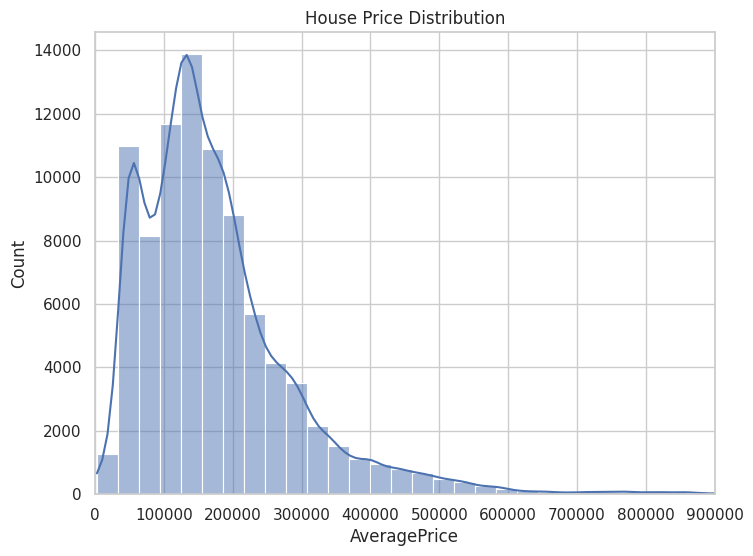

In [10]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.histplot(data=df,x='AveragePrice',bins=50,kde=True)
plt.xlim(0,900000)
plt.title("House Price Distribution")
plt.xlabel("AveragePrice")
plt.ylabel("Count")
plt.show()

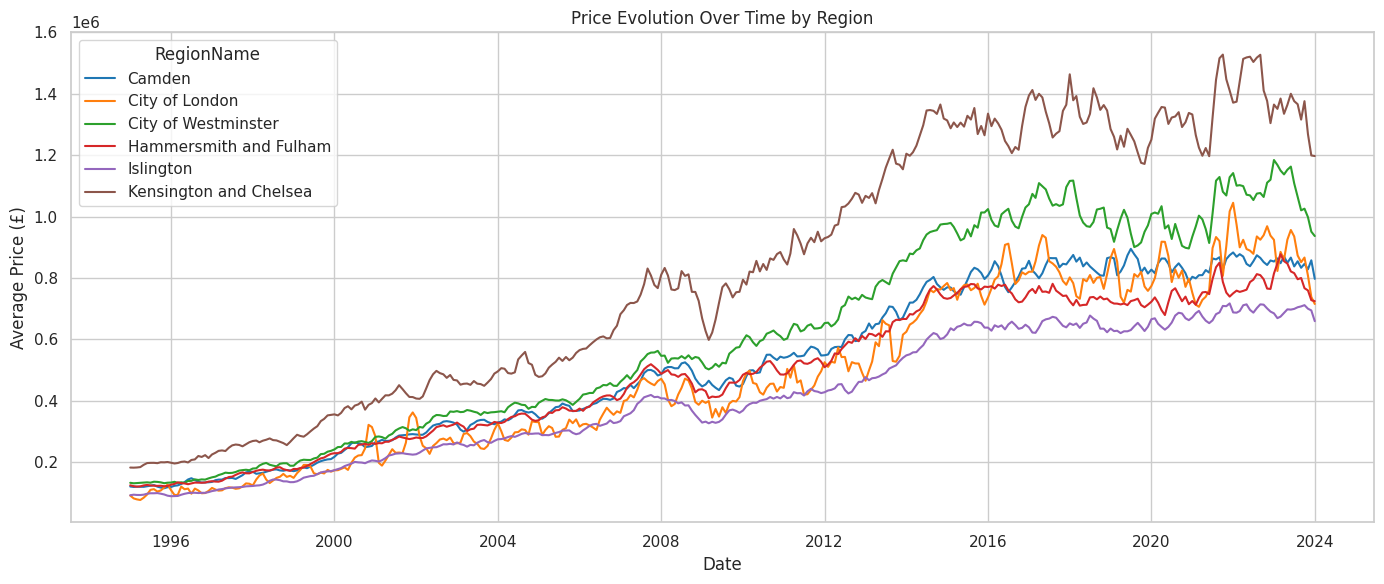

In [11]:
# 1. Price Evolution Over Time by Region (Top 6 for clarity)
top_regions = df.groupby('RegionName')['AveragePrice'].mean().nlargest(6).index
df_top = df[df['RegionName'].isin(top_regions)]
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_top, x='Date', y='AveragePrice', hue='RegionName', palette='tab10')
plt.title('Price Evolution Over Time by Region')
plt.ylabel('Average Price (£)')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-12-fae52b3f7512>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='RegionName', y='AveragePrice', data=df_top_regions, palette='coolwarm')


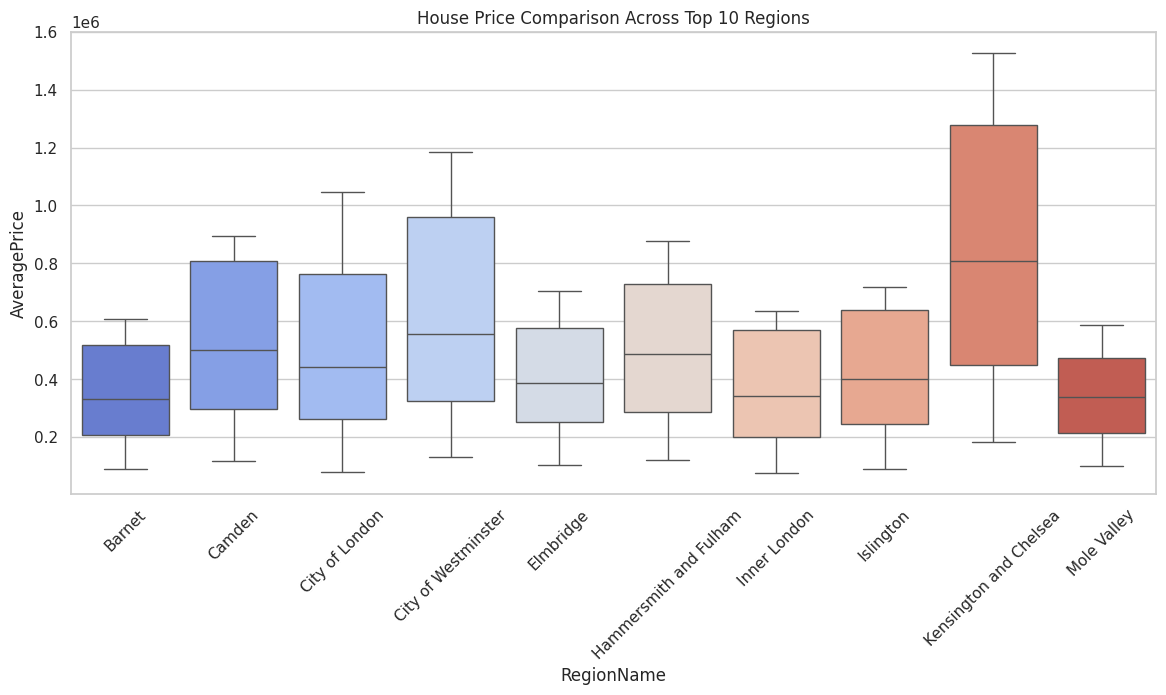

In [12]:
# 4. Boxplot Comparison for Property Types in Top 10 Regions
plt.figure(figsize=(14, 6))
sns.boxplot(x='RegionName', y='AveragePrice', data=df_top_regions, palette='coolwarm')
plt.xticks(rotation=45)
plt.title("House Price Comparison Across Top 10 Regions")
plt.show()

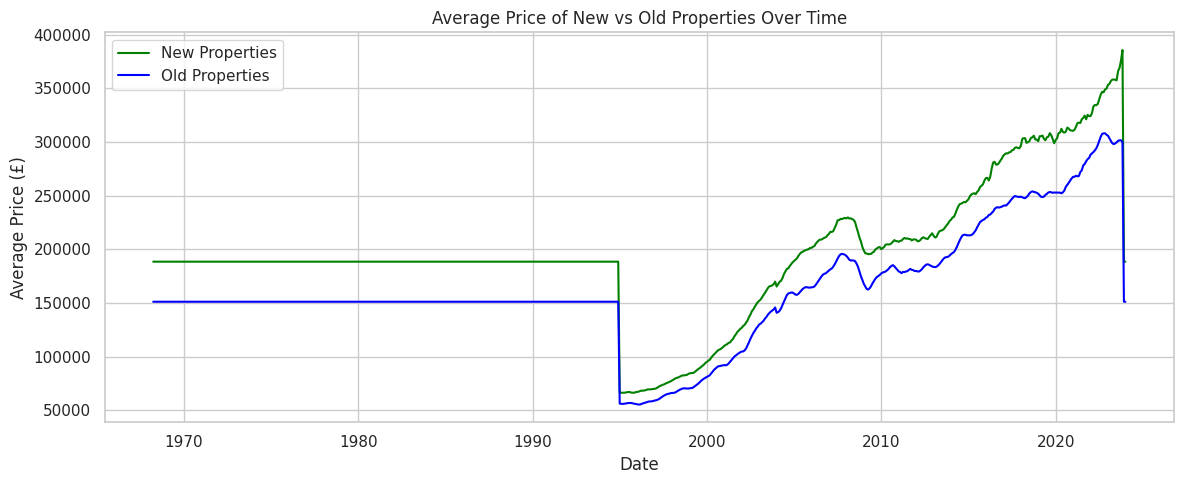

In [13]:
# 2. New vs Old Properties Over Time
monthly_new_old = df.groupby('Date')[['NewPrice', 'OldPrice']].mean().reset_index()
plt.figure(figsize=(12, 5))
plt.plot(monthly_new_old['Date'], monthly_new_old['NewPrice'], label='New Properties', color='green')
plt.plot(monthly_new_old['Date'], monthly_new_old['OldPrice'], label='Old Properties', color='blue')
plt.title('Average Price of New vs Old Properties Over Time')
plt.xlabel('Date')
plt.ylabel('Average Price (£)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

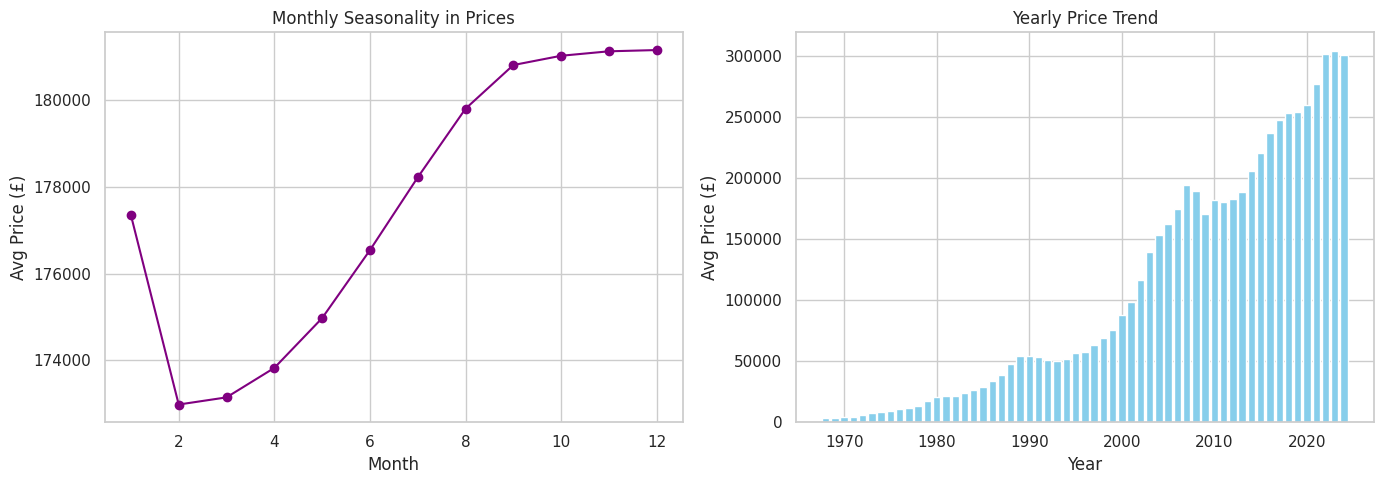

In [14]:
# 3. Monthly & Yearly Seasonality
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# Monthly
df['Month'] = df['Date'].dt.month
monthly_avg = df.groupby('Month')['AveragePrice'].mean()
axes[0].plot(monthly_avg.index, monthly_avg.values, marker='o', color='purple')
axes[0].set_title('Monthly Seasonality in Prices')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Avg Price (£)')
axes[0].grid(True)
# Yearly
df['Year'] = df['Date'].dt.year
yearly_avg = df.groupby('Year')['AveragePrice'].mean()
axes[1].bar(yearly_avg.index, yearly_avg.values, color='skyblue')
axes[1].set_title('Yearly Price Trend')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Avg Price (£)')
axes[1].grid(True)
plt.tight_layout()
plt.show()

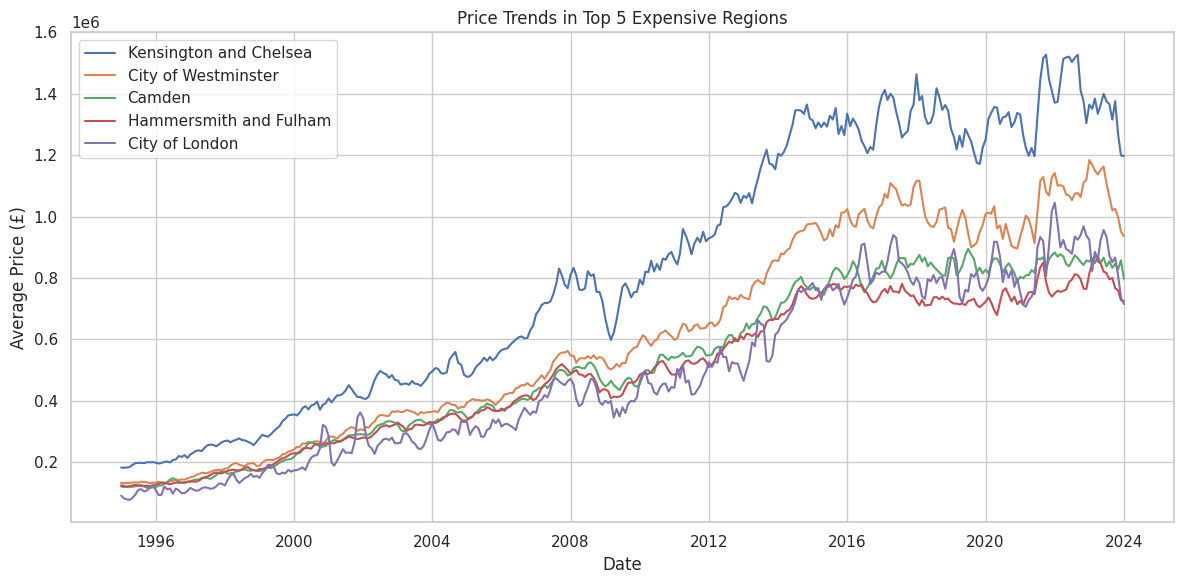

In [15]:
top_5_regions = df.groupby('RegionName')['AveragePrice'].mean().sort_values(ascending=False).head(5).index
plt.figure(figsize=(12, 6))
for region in top_5_regions:
    regional_data = df[df['RegionName'] == region]
    sns.lineplot(x='Date', y='AveragePrice', data=regional_data, label=region)

plt.title('Price Trends in Top 5 Expensive Regions')
plt.xlabel('Date')
plt.ylabel('Average Price (£)')
plt.legend()
plt.tight_layout()
plt.show()


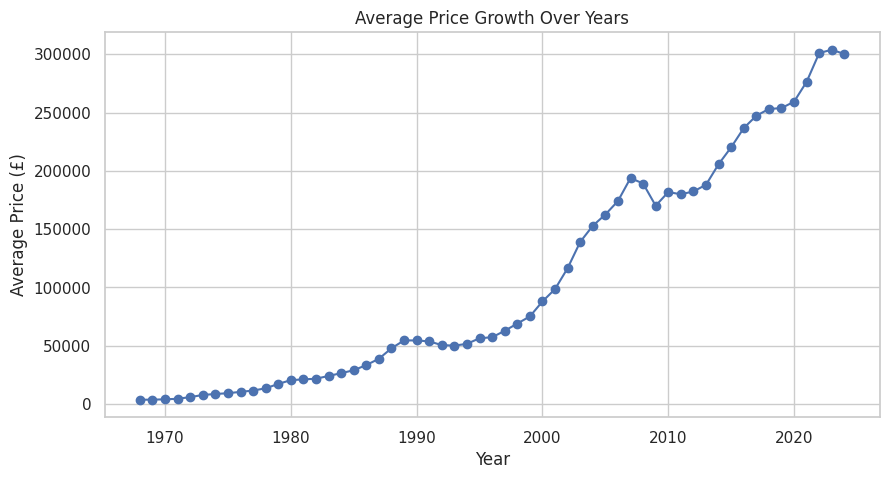

In [16]:
yearly_avg = df.groupby(df['Date'].dt.year)['AveragePrice'].mean()

plt.figure(figsize=(10, 5))
yearly_avg.plot(marker='o')
plt.title("Average Price Growth Over Years")
plt.xlabel("Year")
plt.ylabel("Average Price (£)")
plt.grid(True)
plt.show()


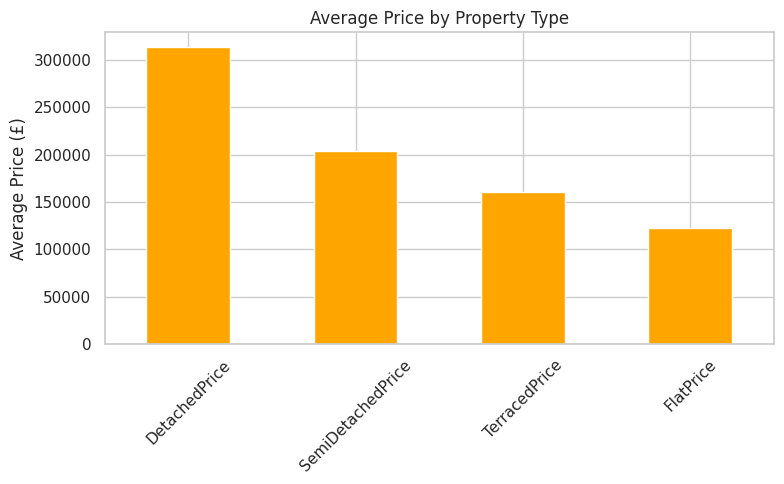

In [17]:
# 4. Comparison of Property Types
property_types = ['DetachedPrice', 'SemiDetachedPrice', 'TerracedPrice', 'FlatPrice']
type_means = df[property_types].mean().sort_values(ascending=False)
plt.figure(figsize=(8, 5))
type_means.plot(kind='bar', color='orange')
plt.title('Average Price by Property Type')
plt.ylabel('Average Price (£)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

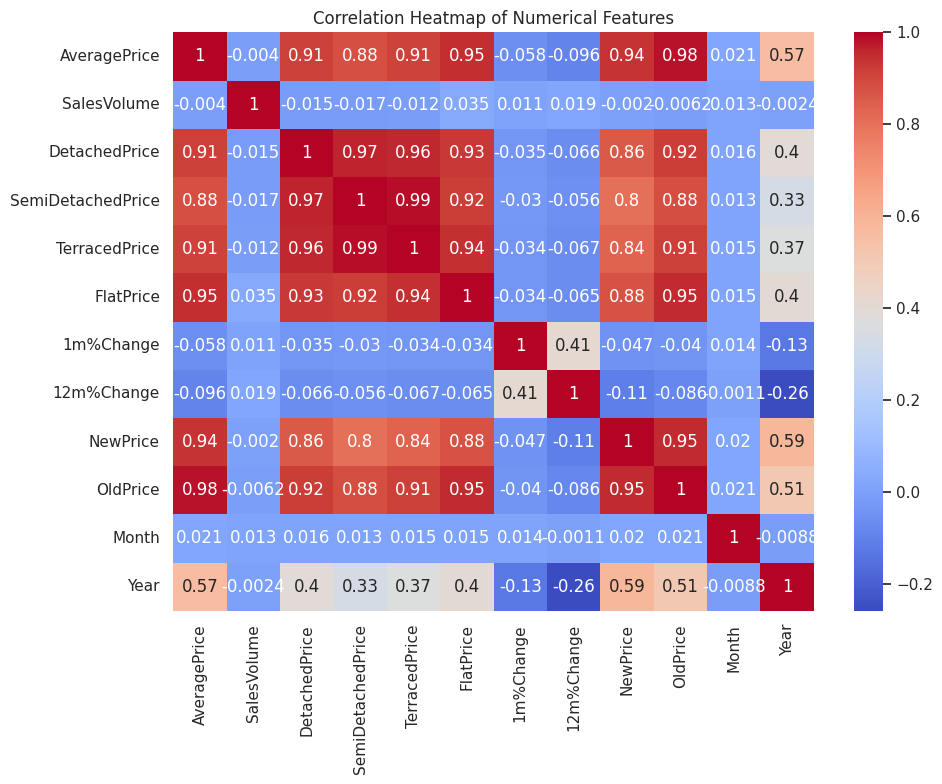

In [18]:
# 13. Correlation Heatmap
plt.figure(figsize=(10, 8))
corr = df.select_dtypes(include='number').corr()
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()

Training: Random Forest
Random Forest - R²: 0.9996, RMSE: 2523.68, MAE: 796.87

Training: Gradient Boosting
Gradient Boosting - R²: 0.9969, RMSE: 6881.26, MAE: 3606.61

Training: Ridge Regression
Ridge Regression - R²: 0.9780, RMSE: 18442.27, MAE: 11054.52

Training: Lasso Regression
Lasso Regression - R²: 0.9780, RMSE: 18442.25, MAE: 11054.41

Training: Support Vector Regression
Support Vector Regression - R²: 0.0569, RMSE: 120774.88, MAE: 75643.21



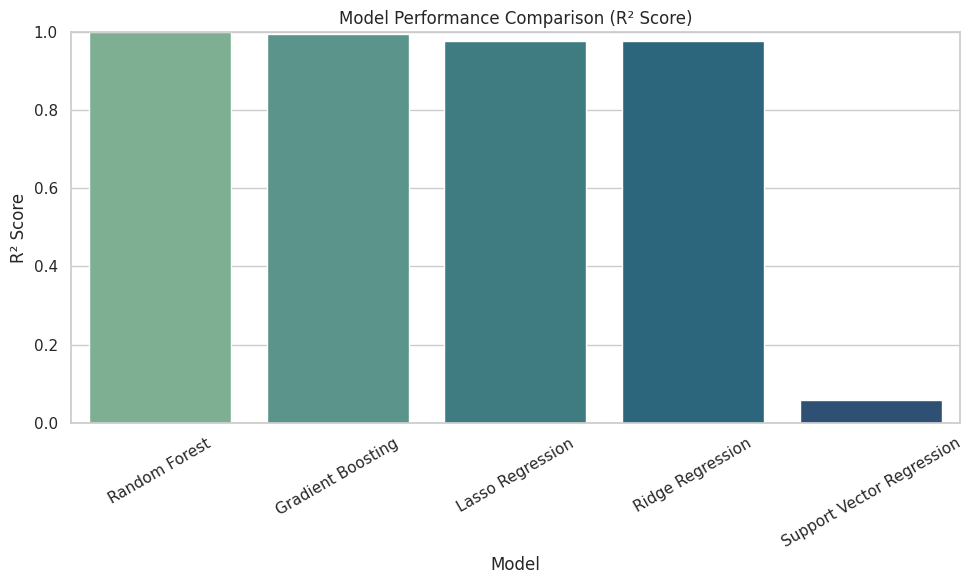

In [19]:
# --- Train & Compare 5 ML Models (Default Settings) ---

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Encode categorical columns if any
from sklearn.preprocessing import LabelEncoder

# Prepare dataset
X = df.drop(columns=['AveragePrice', 'Date'])
y = df['AveragePrice']

# Encode categorical features
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the 5 models (no tuning)
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Support Vector Regression': SVR()
}

# Train, predict, and evaluate
results = {}

for name, model in models.items():
    print(f"Training: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    results[name] = {'R2 Score': r2, 'RMSE': rmse, 'MAE': mae}
    print(f"{name} - R²: {r2:.4f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}\n")

# Convert to DataFrame for plotting
results_df = pd.DataFrame(results).T.sort_values("R2 Score", ascending=False)

# Plot model comparison
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y=results_df['R2 Score'], palette="crest")
plt.title("Model Performance Comparison (R² Score)")
plt.ylabel("R² Score")
plt.xlabel("Model")
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

Training: Random Forest
Random Forest - R²: 0.9228, RMSE: 34545.17, MAE: 16846.14

Training: Gradient Boosting
Gradient Boosting - R²: 0.6909, RMSE: 69144.13, MAE: 44793.78

Training: Ridge Regression
Ridge Regression - R²: 0.3343, RMSE: 101471.51, MAE: 64433.30

Training: Lasso Regression
Lasso Regression - R²: 0.3343, RMSE: 101471.50, MAE: 64433.29

Training: Support Vector Regression
Support Vector Regression - R²: -0.0454, RMSE: 127160.55, MAE: 82423.40



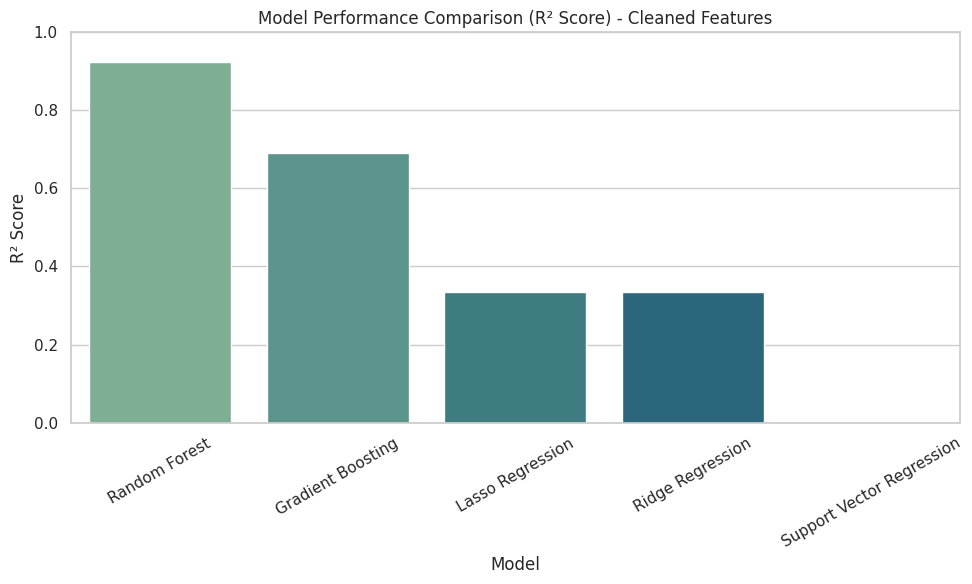

In [20]:
# --- Train & Compare 5 ML Models with Cleaned Features (No Leakage) ---

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Drop leakage-prone columns
leak_cols = ['Date', 'AveragePrice', 'DetachedPrice', 'SemiDetachedPrice', 'TerracedPrice', 'FlatPrice', 'NewPrice', 'OldPrice']
X = df.drop(columns=leak_cols)
y = df['AveragePrice']

# Encode categorical features
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the 5 models (no tuning)
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Support Vector Regression': SVR()
}

# Train, predict, and evaluate
results = {}

for name, model in models.items():
    print(f"Training: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    results[name] = {'R2 Score': r2, 'RMSE': rmse, 'MAE': mae}
    print(f"{name} - R²: {r2:.4f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}\n")

# Convert to DataFrame for plotting
results_df = pd.DataFrame(results).T.sort_values("R2 Score", ascending=False)

# Plot model comparison
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y=results_df['R2 Score'], palette="crest")
plt.title("Model Performance Comparison (R² Score) - Cleaned Features")
plt.ylabel("R² Score")
plt.xlabel("Model")
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


Tuning and training: Random Forest
Best Params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest - R²: 0.8992, RMSE: 39484.04, MAE: 20867.50


Tuning and training: Gradient Boosting
Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Gradient Boosting - R²: 0.9181, RMSE: 35602.53, MAE: 23609.80



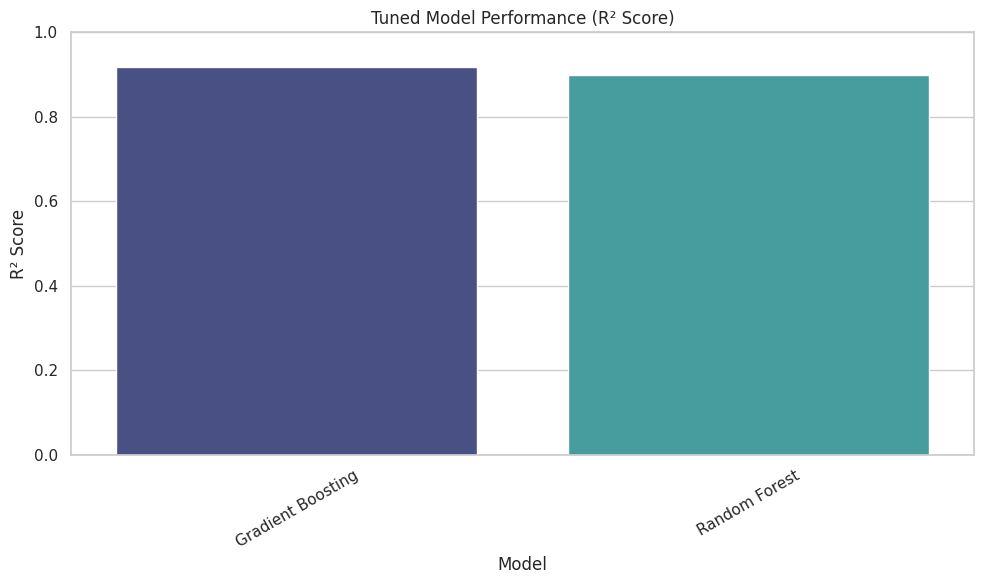

In [21]:
# --- Train, Tune & Compare Top 2 ML Models ---

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Drop leakage-prone columns
leak_cols = ['Date', 'AveragePrice', 'DetachedPrice', 'SemiDetachedPrice', 'TerracedPrice', 'FlatPrice', 'NewPrice', 'OldPrice']
X = df.drop(columns=leak_cols)
y = df['AveragePrice']

# Encode categorical features
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models with hyperparameter grids
models_grid = {
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20],
            'min_samples_split': [2, 5]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5]
        }
    }
}

results = {}
best_models = {}

# Train & tune
for name, cfg in models_grid.items():
    print(f"\nTuning and training: {name}")
    grid = GridSearchCV(cfg['model'], cfg['params'], cv=5, scoring='r2', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    best_models[name] = best_model

    y_pred = best_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    print(f"Best Params: {grid.best_params_}")
    print(f"{name} - R²: {r2:.4f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}\n")

    results[name] = {'R2 Score': r2, 'RMSE': rmse, 'MAE': mae}

# Plot R² comparison
results_df = pd.DataFrame(results).T.sort_values("R2 Score", ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y=results_df['R2 Score'], palette="mako")
plt.title("Tuned Model Performance (R² Score)")
plt.ylabel("R² Score")
plt.xlabel("Model")
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


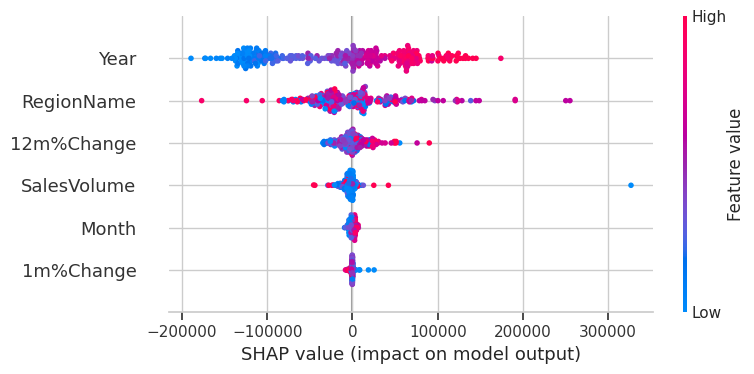

Models saved successfully.


In [22]:
# --- SHAP Explainability for Gradient Boosting ---
import shap

explainer = shap.Explainer(best_models['Gradient Boosting'], X_train)
shap_values = explainer(X_test[:300])
shap.summary_plot(shap_values, X_test[:300])

# --- Save Tuned Models ---
import joblib
import os

if not os.path.exists("saved_models"):
    os.makedirs("saved_models")

joblib.dump(best_models['Random Forest'], "saved_models/random_forest_model.pkl")
joblib.dump(best_models['Gradient Boosting'], "saved_models/gradient_boosting_model.pkl")
print("Models saved successfully.")


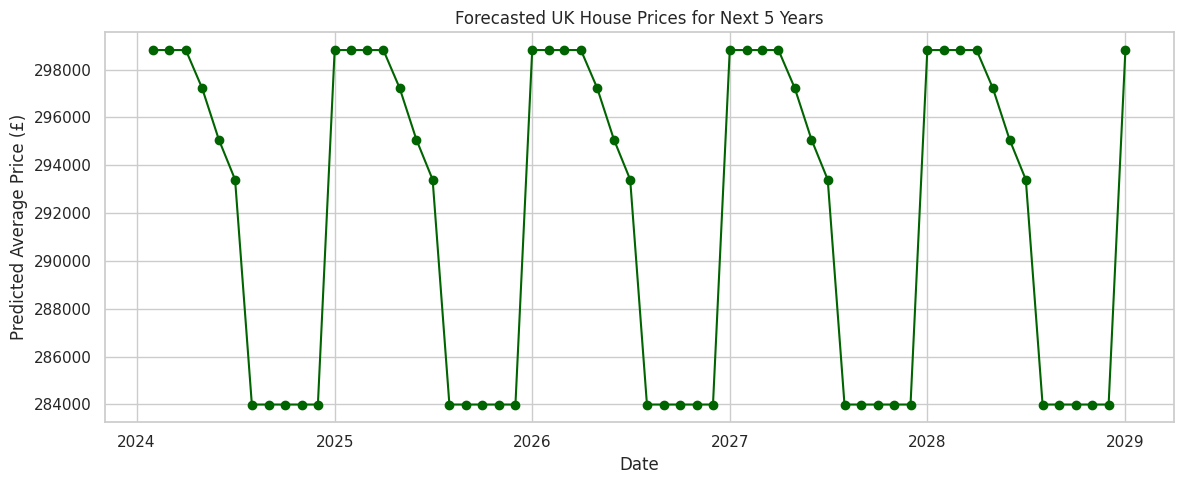

In [24]:
# --- Forecasting Next 5 Years with Gradient Boosting ---
import pandas as pd
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt

# Create future dates
future_dates = pd.date_range(start=df['Date'].max() + DateOffset(months=1), periods=60, freq='MS')

# Use median values of input features for baseline future prediction
future_input = pd.DataFrame([X.median()] * 60)

# If 'Month' and 'Year' are features, update them accordingly
if 'Month' in future_input.columns:
    future_input['Month'] = future_dates.month
if 'Year' in future_input.columns:
    future_input['Year'] = future_dates.year

# Predict future prices
future_preds = best_models['Gradient Boosting'].predict(future_input)

# Create result DataFrame and plot
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Price': future_preds
})

plt.figure(figsize=(12, 5))
plt.plot(future_df['Date'], future_df['Predicted_Price'], marker='o', color='darkgreen')
plt.title('Forecasted UK House Prices for Next 5 Years')
plt.xlabel('Date')
plt.ylabel('Predicted Average Price (£)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [26]:
# --- Final Correct Test Accuracy Evaluation ---

import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from math import sqrt

# Load the dataset
df = pd.read_csv("UK-HPI-full-file-2024-01 (4).csv")

# Keep only important features
required_cols = ['RegionName', 'SalesVolume', '1m%Change', '12m%Change', 'Date', 'AveragePrice']
df = df[required_cols].dropna()

# Create Month and Year
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

# Prepare final X and y
X = df[['RegionName', 'SalesVolume', '1m%Change', '12m%Change', 'Month', 'Year']]
y = df['AveragePrice']

# Encode RegionName
le = LabelEncoder()
X['RegionName'] = le.fit_transform(X['RegionName'])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load saved model
model = joblib.load("saved_models/gradient_boosting_model.pkl")

# Predict
y_pred = model.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))  # <-- fix
mae = mean_absolute_error(y_test, y_pred)

# Print nicely
print(" FINAL TEST RESULTS:")
print(f"   - R² Score : {r2:.4f}")
print(f"   - RMSE (£) : {rmse:.2f}")
print(f"   - MAE (£)  : {mae:.2f}")


 FINAL TEST RESULTS:
   - R² Score : 0.6590
   - RMSE (£) : 69881.90
   - MAE (£)  : 44812.78


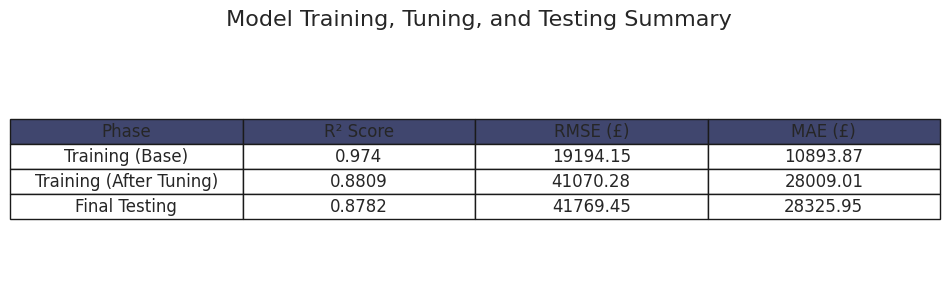

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# --- Assume you already have your models trained ---

# After initial base training
base_model = RandomForestRegressor(random_state=42)
base_model.fit(X_train, y_train)
y_pred_base = base_model.predict(X_train)

training_r2 = r2_score(y_train, y_pred_base)
training_rmse = sqrt(mean_squared_error(y_train, y_pred_base))
training_mae = mean_absolute_error(y_train, y_pred_base)

# After hyperparameter tuning
tuned_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
tuned_model.fit(X_train, y_train)
y_pred_tuned = tuned_model.predict(X_train)

tuned_r2 = r2_score(y_train, y_pred_tuned)
tuned_rmse = sqrt(mean_squared_error(y_train, y_pred_tuned))
tuned_mae = mean_absolute_error(y_train, y_pred_tuned)

# Final Testing
y_pred_test = tuned_model.predict(X_test)
testing_r2 = r2_score(y_test, y_pred_test)
testing_rmse = sqrt(mean_squared_error(y_test, y_pred_test))
testing_mae = mean_absolute_error(y_test, y_pred_test)

# --- Build Summary Table ---

summary_data = {
    "Phase": ["Training (Base)", "Training (After Tuning)", "Final Testing"],
    "R² Score": [round(training_r2, 4), round(tuned_r2, 4), round(testing_r2, 4)],
    "RMSE (£)": [round(training_rmse, 2), round(tuned_rmse, 2), round(testing_rmse, 2)],
    "MAE (£)": [round(training_mae, 2), round(tuned_mae, 2), round(testing_mae, 2)]
}

summary_df = pd.DataFrame(summary_data)

# Plot
fig, ax = plt.subplots(figsize=(8, 3))
ax.axis('tight')
ax.axis('off')

table = ax.table(
    cellText=summary_df.values,
    colLabels=summary_df.columns,
    loc='center',
    cellLoc='center',
    colColours=["#40466e"]*4
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.5, 1.5)

plt.title(" Model Training, Tuning, and Testing Summary", pad=20, fontsize=16)
plt.show()
